In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys,time
#from utils import *
from scipy.stats import pearsonr

In [2]:
project1 = "BRCA"
project2 = "CPTAC-BRCA"

task_name = "GE"
path2target = "../10metadata/"
result_dir = f"analysis_results/"
path2val = f"../../CPTAC-BRCA/"

In [3]:
def compute_coef(labels, preds):
    coef = np.array([pearsonr(labels[:,i], preds[:,i])[0] for i in range(labels.shape[1])])
    print(sum(coef > 0.4),sum(coef > 0.45),sum(coef > 0.5), sum(coef > 0.55), sum(coef > 0.6))
    return coef

In [4]:
#genes_source = np.loadtxt(f"{path2target}{project1}_genes.txt", dtype="str")
#genes_source = genes_source[:,0]
genes_source = pd.read_csv(f"{path2target}{project2}_genes.csv")
genes_source = genes_source["gene"].values

n_genes = len(genes_source)
print("n_genes:", n_genes)

n_genes: 18272


In [5]:
#genes_target = np.loadtxt(f"{path2target}{project2}_genes.txt", dtype="str")
genes_target = pd.read_csv(f"{path2val}10metadata/{project2}_genes.csv")
genes_target = genes_target["gene"].values
print(genes_target.shape)

genes = np.intersect1d(genes_source, genes_target)
print(genes)
print(genes.shape)

cols = np.hstack(("patient_id", genes))

(18272,)
['A1BG' 'A1BG-AS1' 'A2M' ... 'ZZZ3' 'pk' 'snoU109']
(18272,)


In [6]:
df_pred = pd.read_pickle(f"{result_dir}{project2}_beta_test_pred.pkl")
#print(df_pred)
#df_actual = pd.read_pickle(f"../12target/{project2}_log.pkl")
df_actual = pd.read_pickle(f"{path2val}14Classification/analysis_results/{project2}_beta_test_actual.pkl")
#print(df_actual.shape)

## select only commond genes
df_pred = df_pred[cols]
df_actual = df_actual[cols]

## aggregate to patient level:
df_actual_patient = df_actual.groupby(["patient_id"], as_index=False).aggregate("mean")
df_pred_patient = df_pred.groupby(["patient_id"], as_index=False).aggregate("mean")
#print(df_actual_patient)

# %%
actual_patient = df_actual_patient[genes].values
pred_patient = df_pred_patient[genes].values
print(actual_patient.shape, pred_patient.shape)
coef = compute_coef(actual_patient, pred_patient)
#print(actual_patient)

df_actual_patient.to_pickle(f"{result_dir}{project2}_actual_patient.pkl")
df_pred_patient.to_pickle(f"{result_dir}{project2}_pred_patient.pkl")

(106, 18272) (106, 18272)
3376 2294 1507 929 518


In [7]:
df_coef = pd.DataFrame(data={"gene": genes, "coef": coef})

df_coef.to_csv(f"{result_dir}coef.csv", index=None)
df_sorted = df_coef.sort_values(by="coef", ascending=False)                   
df_sorted.to_csv(f"{result_dir}coef_sorted.csv", index=None)

In [8]:
## cumulative: number of genes with coefs_mean (over 5 folds) > threshold
coef0 = np.linspace(0.4, 0.8, 41, endpoint=True)
n = np.zeros(len(coef0))
for i, t in enumerate(coef0):
    n[i] = sum(coef > t)
    #print(i, t, n[i])
    
df_thrsd = pd.DataFrame(data={"thrsd": coef0, "n_genes": n})
df_thrsd.to_csv(f"{result_dir}n_genes_thrsd.csv", index=None)

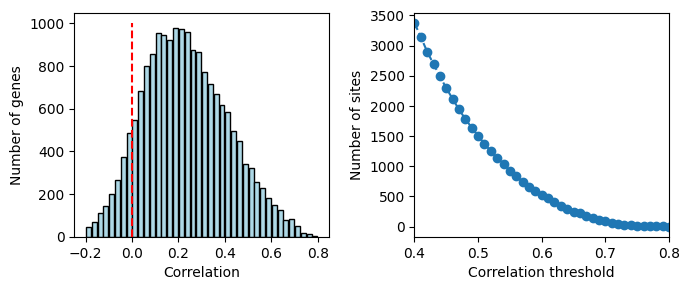

In [9]:
nx,ny = 2,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*3))

bins1 = np.linspace(-0.2,0.8,41, endpoint=True)
ax[0].hist(coef,bins=bins1,histtype='bar',color="lightblue",edgecolor="black",rwidth=0.85)
#ax[0].plot([R0_min, R0_min],[0,50000], "--", color="red", label="p-adj=0.05")
#ax[0].plot([0, 0],[0,2000], "--", color="red", label="p-adj=0.05")
ax[0].vlines(0,0,1000,linestyles="dashed", colors="red")
ax[0].set_xlabel("Correlation")
ax[0].set_ylabel("Number of genes")
ax[0].set_xticks([-0.2,0,0.2,0.4,0.6,0.8])
#ax[0].set_ylim(0,2000)
#ax[0].set_yticks([500,1000,1500,2000])
#ax[0].legend()

ax[1].plot(coef0,n, "o--", label="DeepPT")
ax[1].set_xlabel("Correlation threshold")
ax[1].set_ylabel("Number of sites")
ax[1].set_xlim(0.4,0.8)
#ax[1].plot(0.4,786, "^", label="HE2RNA")

#ax[1].legend()
plt.tight_layout(h_pad=1, w_pad= 1.5)
plt.savefig(f"{result_dir}hist_cum.pdf", format='pdf', dpi=50)